Trees

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import os
import re
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sklearn.tree as tree
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import warnings

In [2]:
os.getcwd()
from thon.Choose import choose_features
from thon.churn import rollover, save_model, tree_importance, plot_eval, bake_pred
# data = choose_features("data/out/features.csv", cv_range = (0, 10), save = False)

In [3]:
# features are automatically trimmed
data = pd.read_csv("data/out/features.csv")
data.columns

Index(['month', 'n', '10yinf_lag9', 'altsales_lag3', 'durable_lag9',
       'g_car_lag3', 'g_new_cars_lag3', 'g_tips_for_buying_a_car_lag9',
       'g_used_cars_lag3', 'kwhcost_lag3', 'localrent_lag3',
       'localunemp_lag12', 'ltrucksa_lag3', 'miles_lag12', 'new_units_lag6',
       'newhouses_lag3', 'ngf_lag12', 'ngspot_lag3', 'oil_lag9',
       'sahmrule_lag9', 'sentiment_lag3', 'TM_lag12', 'TM_v_lag3',
       'tmaturity_lag12', 'totalsa_lag3', 'unemployment_lag12', 'XOM_lag12',
       'XOM_v_lag6'],
      dtype='object')

In [4]:
# Training data
X, y = data.drop(columns = ['n']), data['n']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, shuffle = False)

In [5]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DecisionTreeRegressor())
])

In [25]:
search = GridSearchCV(pipeline,
                      {'model__max_depth':np.arange(2, 20, 1),
                      'model__ccp_alpha':np.arange(0, 5, 0.1)},                      
                      cv = 5,
                      scoring = 'neg_mean_squared_error',
                      verbose = 1)

In [26]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 900 candidates, totalling 4500 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', DecisionTreeRegressor())]),
             param_grid={'model__ccp_alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9]),
                         'model__max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19])},
             scoring='neg_mean_squared_error', verbose=1)

In [27]:
search.best_params_

{'model__ccp_alpha': 4.6000000000000005, 'model__max_depth': 2}

In [28]:
# Training data

# Train the model
treemodel = DecisionTreeRegressor(max_depth= search.best_params_.get("model__max_depth"), 
                                  ccp_alpha = search.best_params_.get("model__ccp_alpha"),
                                  random_state = 0) 
treemodel.fit(X_train, y_train)

# Store the fitted values as a time series with the same time index as
# the training data
train_pred = pd.Series(treemodel.predict(X_train), index=X_train.index)
test_pred = pd.Series(treemodel.predict(X_test), index=X_test.index)

In [29]:
train_pred = train_pred.sort_index()
y_train = y_train.sort_index()
test_pred = test_pred.sort_index()
y_test = y_test.sort_index()

946.1959684125582


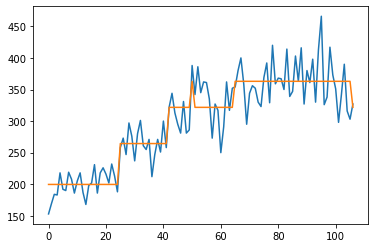

In [30]:
plot_eval(train_pred, y_train)

7465.533392501407


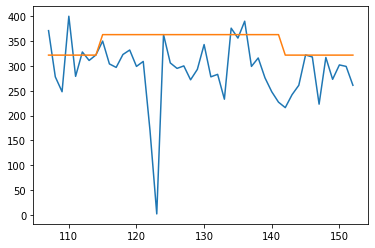

In [31]:
plot_eval(test_pred, y_test)

In [32]:
text_representation = tree.export_text(treemodel, feature_names = list(X_train))
print(text_representation)

|--- localrent_lag3 <= 273.61
|   |--- month <= 25.50
|   |   |--- value: [199.68]
|   |--- month >  25.50
|   |   |--- value: [264.41]
|--- localrent_lag3 >  273.61
|   |--- 10yinf_lag9 <= 2.08
|   |   |--- value: [362.98]
|   |--- 10yinf_lag9 >  2.08
|   |   |--- value: [321.74]



In [33]:
# feature names used in model
imp = get_tree_importance(treemodel, X_train.columns)

In [34]:
save_model(treemodel, "treemodel.pkl")

In [35]:
imp.sort_values("importance", ascending = False)

,importance
localrent_lag3,0.849805
month,0.094106
10yinf_lag9,0.056089
ngf_lag12,0.000000
XOM_lag12,0.000000
unemployment_lag12,0.000000
totalsa_lag3,0.000000
tmaturity_lag12,0.000000
TM_v_lag3,0.000000
TM_lag12,0.000000


In [36]:
newdata = rollover(imp)

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Features are named incorrectly, they are led 3 months ahead of their label


In [37]:
newdata

,month,10yinf_lag9,altsales_lag3,durable_lag9,g_car_lag3,g_new_cars_lag3,g_tips_for_buying_a_car_lag9,g_used_cars_lag3,kwhcost_lag3,localrent_lag3,...,oil_lag9,sahmrule_lag9,sentiment_lag3,TM_lag12,TM_v_lag3,tmaturity_lag12,totalsa_lag3,unemployment_lag12,XOM_lag12,XOM_v_lag6
0,154,2.45,0,0,0,0,0,0,0,432.474,...,0,0,0,0,0,0,0,0,0,0
1,155,2.46,0,0,0,0,0,0,0,435.210,...,0,0,0,0,0,0,0,0,0,0
2,156,2.85,0,0,0,0,0,0,0,439.701,...,0,0,0,0,0,0,0,0,0,0


In [38]:
# predict
pred = treemodel.predict(newdata)
pred

array([321.73913043, 321.73913043, 321.73913043])

In [39]:
full = bake_pred(y_train, y_test, pred)

In [40]:
full.to_csv("data/out/tree.csv")

In [41]:
full

,n,group
0,153.00000,train
1,169.00000,train
2,184.00000,train
3,183.00000,train
4,218.00000,train
...,...,...
151,299.00000,test
152,261.00000,test
153,321.73913,pred
154,321.73913,pred
